# Code for figure 1 (EI of simple networks with different activation functions)

In [7]:
import os
from pathlib import Path
import pickle
from collections import defaultdict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from tqdm import tqdm

import torch
import torch.nn as nn

from deep_ei import topology_of, ei_of_layer

## Define colormaps

In [8]:
def greyscaleMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("binary")
    return colormap((((0.6 / size * pos) + 0.1)))

def magmaMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("magma")
    return colormap(1.0 * pos / size)

def blueMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("Blues")
    return colormap(0.85 * pos / size + 0.15) # avoid using the lightest blue color -- it's not visible

## Set device

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
dtype = torch.float32
torch.set_default_dtype(dtype)
print(f"Using device: {device}")

Using device: cpu


## A -> B Sigmoid Plot

In [10]:
sigmoid_1d_eis = defaultdict(list)

In [12]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

ws = np.arange(0, 27, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in tqdm(binSizes):
    color = blueMap(binSizes, binSize)
    for w in ws:
        singleton.weight.data[0][0] = w
        sigmoid_1d_eis[binSize].append(ei_of_layer(singleton, top, 
                               samples=30000, 
                               batch_size=1000,  
                               in_range=(0, 1),
                               in_bins=binSize,
                               out_range=(0, 1), 
                               out_bins=binSize,
                               activation=nn.Sigmoid(), 
                               device=device))

100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


In [15]:
1.7 * 2/3

1.1333333333333333

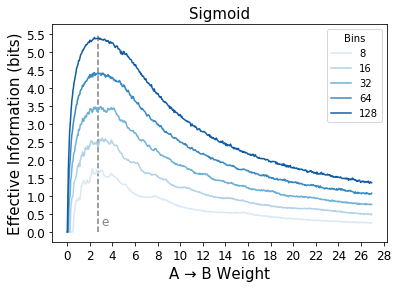

In [47]:
# plt.figure(figsize=(1.7, 1.13))
fig, ax = plt.subplots(1, 1) #figsize=(1.7, 1.13))

# Plot the vertical line indicating e
plt.plot((np.e, np.e), (0, 5.5), '--', color='grey')
plt.text(np.e + 0.3, 0.2, "e", fontsize=12, color='grey')

# ws = np.arange(0, 27, 0.05)
# binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    ax.plot(ws, sigmoid_1d_eis[binSize], color=color, label=str(binSize))

ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)

ax.set_title("Sigmoid", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
plt.legend(title="Bins", loc="upper right")

plt.savefig("figures/sigmoid-1d-blue-labeled.pdf", dpi=300, bbox_inches='tight')

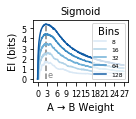

In [41]:
# plt.figure(figsize=(1.7, 1.13))
fig, ax = plt.subplots(1, 1, figsize=(1.7, 1.13))

# Plot the vertical line indicating e
plt.plot((np.e, np.e), (0, 5.5), '--', color='grey')
plt.text(np.e + 0.3, 0.2, "e", fontsize=8, color='grey')

# ws = np.arange(0, 27, 0.05)
# binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    ax.plot(ws, sigmoid_1d_eis[binSize], color=color, label=str(binSize))

ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1.0))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.tick_params(axis='both',which='major',labelsize=8)

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)

ax.set_title("Sigmoid", fontsize=10)
ax.set_xlabel('A → B Weight', fontsize=10)
ax.set_ylabel('EI (bits)',fontsize=10)
plt.legend(title="Bins", loc="upper right", fontsize=8, prop={'size': 6})

plt.savefig("figures/sigmoid-1d-blue-labeled-tiny.pdf", dpi=300, bbox_inches='tight')

### Is it definitely peaking at e?

In [20]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))
binsizes= [32, 64, 128, 256]

ws = np.arange(0, 4, 0.001)
eis = defaultdict(list)
for b in tqdm(binsizes):
    for w in ws:
        singleton.weight.data[0][0] = w
        eis[b].append(ei_of_layer(singleton, top, 
                               samples=100000, 
                               batch_size=1000,  
                               in_range=(0, 1),
                               in_bins=b,
                               out_range=(0, 1), 
                               out_bins=b,
                               activation=nn.Sigmoid(), 
                               device=device))

In [21]:
peaks = []
for b in binsizes:
    i = max(range(len(ws)), key=lambda i: eis[b][i])
    peaks.append(ws[i])
    print(ws[i])

2.988
2.633
2.665
2.809


In [22]:
sum(peaks) / 4

2.7737500000000006

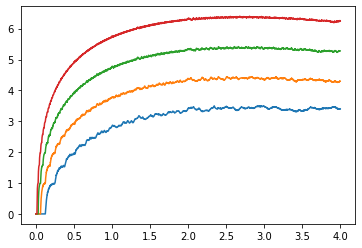

In [23]:
for b in [32, 64, 128, 256]:
    plt.plot(ws, eis[b])

## A, B -> C Sigmoid Plot

KeyboardInterrupt: 

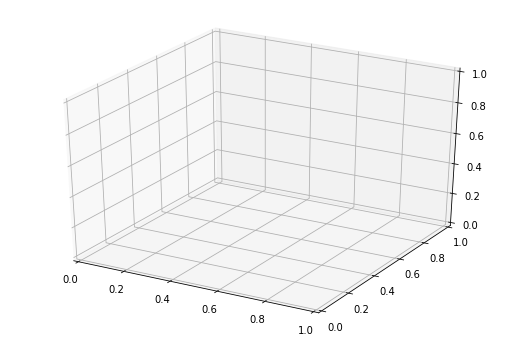

In [44]:
tiny_network = nn.Linear(2, 1, bias=False).to(device)
top = topology_of(tiny_network, input=torch.zeros(1, 2).to(device))

bins = 64
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -10.0, 10.0
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
x = y = np.arange(lbound, ubound, stepSize)
X, Y = np.meshgrid(x, y)
rX,rY = np.ravel(X), np.ravel(Y)

eis = []
for i in range(evalPoints * evalPoints):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    EI = ei_of_layer(tiny_network, top, 
                     samples=30000, 
                     batch_size=1000, 
                     in_range=(0, 1),
                     in_bins=bins,
                     out_range=(0, 1),
                     out_bins=bins,
                     activation=nn.Sigmoid(), device=device)
    eis.append(EI)
    
zs = np.array(eis)
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=plt.cm.Blues)

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=9)

ax.set_title("Sigmoid", fontsize=15, x=0.7, y=0.965)
ax.set_xlabel('A → C Weight', fontsize=15)
ax.set_ylabel('B → C Weight', fontsize=15)
ax.set_zlabel('Effective Information (bits)', fontsize=15)

plt.savefig("figures/sigmoid-2d-blue", dpi=300, bbox_inches='tight')

100%|██████████| 10000/10000 [00:58<00:00, 172.37it/s]


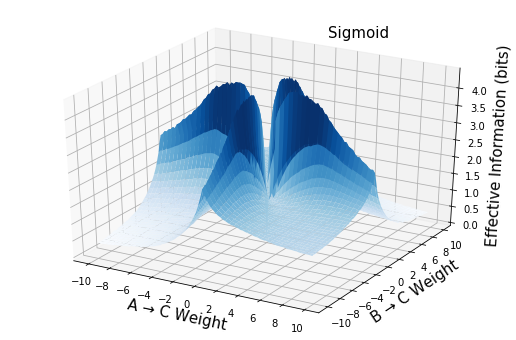

In [51]:
tiny_network = nn.Linear(2, 1, bias=False).to(device)
top = topology_of(tiny_network, input=torch.zeros(1, 2).to(device))

bins = 64
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -10.0, 10.0
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
x = y = np.arange(lbound, ubound, stepSize)
X, Y = np.meshgrid(x, y)
rX,rY = np.ravel(X), np.ravel(Y)

eis = []
for i in tqdm(range(evalPoints * evalPoints)):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    EI = ei_of_layer(tiny_network, top, 
                     samples=30000, 
                     batch_size=1000, 
                     in_range=(0, 1),
                     in_bins=bins,
                     out_range=(0, 1),
                     out_bins=bins,
                     activation=nn.Sigmoid(), device=device)
    eis.append(EI)
    
zs = np.array(eis)
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=plt.cm.Blues)

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=10)

ax.set_title("Sigmoid", fontsize=15, x=0.7, y=0.965)
ax.set_xlabel('A → C Weight', fontsize=15)
ax.set_ylabel('B → C Weight', fontsize=15)
ax.set_zlabel('Effective Information (bits)', fontsize=15)

plt.savefig("figures/sigmoid-2d-blue.pdf", dpi=300, bbox_inches='tight')

## A -> B Tanh

In [27]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

ws = np.arange(0, 2, 0.001)
eis= []
for w in ws:
    singleton.weight.data[0][0] = w
    eis.append(ei_of_layer(singleton, top, 
                           samples=10000, 
                           batch_size=1000,  
                           in_range=(-1, 1),
                           in_bins=binSize,
                           out_range=(-1, 1), 
                           out_bins=binSize,
                           activation=nn.Tanh(), 
                           device=device))

In [28]:
i = max(range(len(ws)), key=lambda i: eis[i])
print(ws[i])

1.2


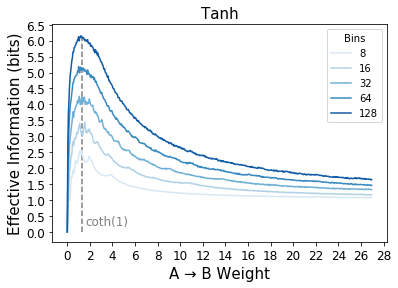

In [48]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

# Plot the vertical line indicating coth(1)
plt.plot((1/np.tanh(1), 1/np.tanh(1)), (0, 6.2), '--', color='grey')
plt.text(1/np.tanh(1) + 0.3, 0.2, "coth(1)", fontsize=12, color='grey')

ws = np.arange(0, 27, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(ei_of_layer(singleton, top, 
                               samples=30000, 
                               batch_size=1000,  
                               in_range=(-1, 1),
                               in_bins=binSize,
                               out_range=(-1, 1), 
                               out_bins=binSize,
                               activation=nn.Tanh(), 
                               device=device))
    ax.plot(ws, eis, color=color, label=str(binSize))

ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)

ax.set_title("Tanh", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
plt.legend(title="Bins", loc="upper right")

plt.savefig("figures/tanh-1d-blue-labeled.pdf", dpi=300, bbox_inches='tight')

In [43]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))
binsizes= [128, 256, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300]

ws = np.arange(0.5, 3, 0.001)
eis = defaultdict(list)
for b in tqdm(binsizes):
    for w in ws:
        singleton.weight.data[0][0] = w
        eis[b].append(ei_of_layer(singleton, top, 
                               samples=100000, 
                               batch_size=1000,  
                               in_range=(-1, 1),
                               in_bins=b,
                               out_range=(-1, 1), 
                               out_bins=b,
                               activation=nn.Tanh(), 
                               device=device))

In [44]:
peaks = []
for b in binsizes:
    i = max(range(len(ws)), key=lambda i: eis[b][i])
    peaks.append(ws[i])
    print(ws[i])

1.0170000000000003
1.0070000000000006
1.0090000000000003
1.3400000000000007
1.0040000000000004
1.0010000000000003
1.0020000000000004
1.3570000000000007
1.2650000000000006
1.1420000000000006
1.2610000000000006
1.2320000000000007
1.1820000000000006


(0.5, 3)

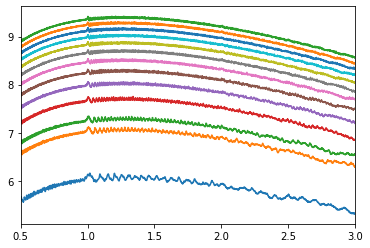

In [46]:
for b in binsizes:
    plt.plot(ws, eis[b])
plt.xlim(0.5, 3)

In [59]:
peaks = []
chunk_s = 40
print(f"resolution: {chunk_s*0.001}")
for b in binsizes:
    m = 0
    m_i = 0
    for i in range(len(ws)-chunk_s):
        avg = sum(eis[b][i:i+chunk_s]) / chunk_s
        if avg > m:
            m = avg
            m_i = i + (chunk_s // 2)
    peaks.append(ws[m_i])
    print(ws[m_i])

resolution: 0.04
1.0160000000000005
1.0080000000000005
1.0060000000000004
1.2630000000000008
1.2640000000000007
1.2830000000000008
1.3270000000000008
1.2680000000000007
1.2910000000000008
1.2630000000000008
1.2560000000000007
1.2410000000000005
1.2590000000000008


In [60]:
from math import *

In [120]:
np.mean(peaks[3:])

1.2715000000000007

In [121]:
np.std(peaks[3:])

0.022655021518418448

In [139]:
1/tanh(1)

1.3130352854993315

### Although $\coth(1)$ does not perfectly fit, after some trial and error it seems to be the cleanest expression close to the true value

## A, B -> C Tanh

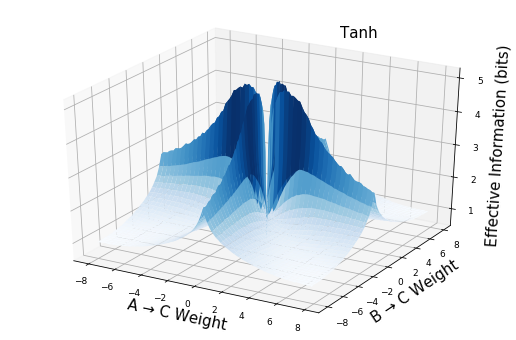

In [159]:
tiny_network = nn.Linear(2, 1, bias=False).to(device)
top = topology_of(tiny_network, input=torch.zeros(1, 2).to(device))

bins = 64
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -8.0, 8.0
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
x = y = np.arange(lbound, ubound, stepSize)
X, Y = np.meshgrid(x, y)
rX,rY = np.ravel(X), np.ravel(Y)

eis = []
for i in range(evalPoints * evalPoints):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    EI = ei_of_layer(tiny_network, top, 
                     samples=30000, 
                     batch_size=1000, 
                     in_range=(-1, 1),
                     in_bins=bins,
                     out_range=(-1, 1),
                     out_bins=bins,
                     activation=nn.Tanh(), 
                     device=device)
    eis.append(EI)
    
zs = np.array(eis)
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=plt.cm.Blues)

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
ax.tick_params(axis='both',which='major',labelsize=9)

ax.set_title("Tanh", fontsize=15, x=0.7, y=0.965)
ax.set_xlabel('A → C Weight', fontsize=15)
ax.set_ylabel('B → C Weight', fontsize=15)
ax.set_zlabel('Effective Information (bits)', fontsize=15)

plt.savefig("figures/tanh-2d-blue", dpi=300, bbox_inches='tight')

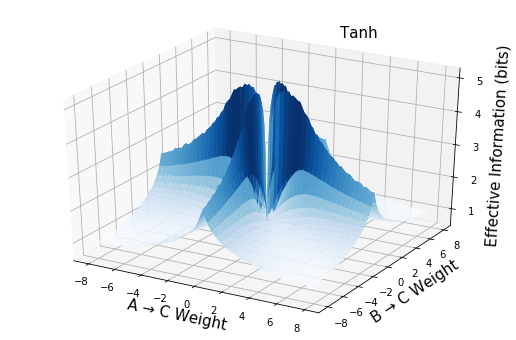

In [52]:
tiny_network = nn.Linear(2, 1, bias=False).to(device)
top = topology_of(tiny_network, input=torch.zeros(1, 2).to(device))

bins = 64
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -8.0, 8.0
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
x = y = np.arange(lbound, ubound, stepSize)
X, Y = np.meshgrid(x, y)
rX,rY = np.ravel(X), np.ravel(Y)

eis = []
for i in range(evalPoints * evalPoints):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    EI = ei_of_layer(tiny_network, top, 
                     samples=30000, 
                     batch_size=1000, 
                     in_range=(-1, 1),
                     in_bins=bins,
                     out_range=(-1, 1),
                     out_bins=bins,
                     activation=nn.Tanh(), 
                     device=device)
    eis.append(EI)
    
zs = np.array(eis)
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=plt.cm.Blues)

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
ax.tick_params(axis='both',which='major',labelsize=10)

ax.set_title("Tanh", fontsize=15, x=0.7, y=0.965)
ax.set_xlabel('A → C Weight', fontsize=15)
ax.set_ylabel('B → C Weight', fontsize=15)
ax.set_zlabel('Effective Information (bits)', fontsize=15)

plt.savefig("figures/tanh-2d-blue.pdf", dpi=300, bbox_inches='tight')

## A -> B ReLU: [0, 1] -> [0, 1]

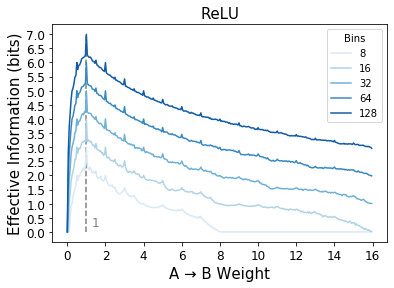

In [53]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

# Plot the vertical line indicating 1
plt.plot((1, 1), (0, 7), '--', color='grey')
plt.text(1 + 0.3, 0.2, "1", fontsize=12, color='grey')

ws = np.arange(0, 16, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(ei_of_layer(singleton, top, 
                               samples=30000, 
                               batch_size=1000, 
                               in_range=[0, 1],
                               in_bins=binSize,
                               out_range=[0, 1], 
                               out_bins=binSize,
                               activation=nn.ReLU(), 
                               device=device))  
    ax.plot(ws, eis, color=color, label=str(binSize))
    
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)

ax.set_title("ReLU", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
plt.legend(title="Bins", loc="upper right")

plt.savefig("figures/relu_0_1_0_1_1d_blue-labeled", dpi=300, bbox_inches='tight')

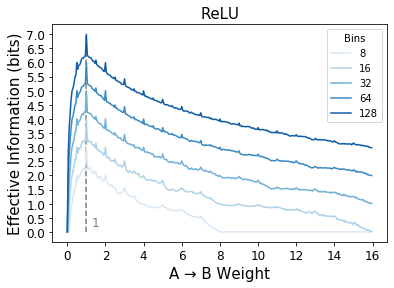

In [50]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

# Plot the vertical line indicating 1
plt.plot((1, 1), (0, 7), '--', color='grey')
plt.text(1 + 0.3, 0.2, "1", fontsize=12, color='grey')

ws = np.arange(0, 16, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(ei_of_layer(singleton, top, 
                               samples=30000, 
                               batch_size=1000, 
                               in_range=[0, 1],
                               in_bins=binSize,
                               out_range=[0, 1], 
                               out_bins=binSize,
                               activation=nn.ReLU(), 
                               device=device))  
    ax.plot(ws, eis, color=color, label=str(binSize))
    
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)

ax.set_title("ReLU", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
plt.legend(title="Bins", loc="upper right")

plt.savefig("figures/relu_0_1_0_1_1d_blue-labeled.pdf", dpi=300, bbox_inches='tight')

## A, B -> C ReLU: [0, 1] -> [0, 1]

 16%|█▋        | 1641/10000 [00:15<01:20, 103.40it/s]


KeyboardInterrupt: 

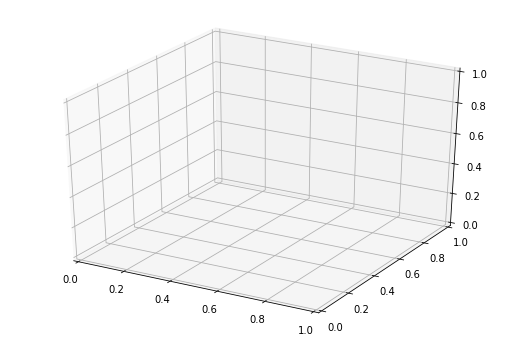

In [54]:
tiny_network = nn.Linear(2, 1, bias=False).to(device)
top = topology_of(tiny_network, input=torch.zeros(1, 2).to(device))

bins = 64
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -6, 6
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
x = y = np.arange(lbound, ubound, stepSize)
X, Y = np.meshgrid(x, y)
rX,rY = np.ravel(X), np.ravel(Y)

eis = []
for i in tqdm(range(evalPoints * evalPoints)):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    EI = ei_of_layer(tiny_network, top, 
                     samples=30000, 
                     batch_size=1000, 
                     in_range=(0, 1),
                     in_bins=64,
                     out_range=(0, 1), 
                     out_bins=64,
                     activation=nn.ReLU(), 
                     device=device)
    eis.append(EI)
    
zs = np.array(eis)
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=plt.cm.Blues)

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
ax.tick_params(axis='both',which='major',labelsize=10)

ax.set_title("ReLU", fontsize=15, x=0.7, y=0.965)
ax.set_xlabel('A → C Weight', fontsize=15)
ax.set_ylabel('B → C Weight', fontsize=15)
ax.set_zlabel('Effective Information (bits)', fontsize=15)

plt.savefig("figures/relu_0_1_0_1_2d-blue", dpi=300, bbox_inches='tight')

100%|██████████| 10000/10000 [01:04<00:00, 156.18it/s]


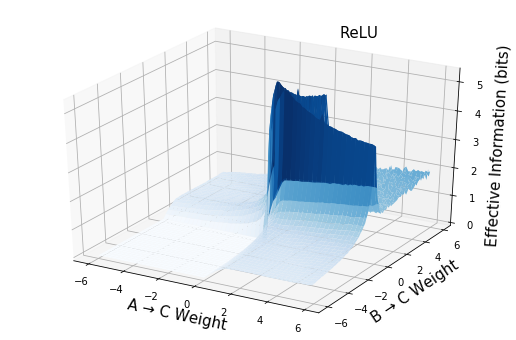

In [55]:
tiny_network = nn.Linear(2, 1, bias=False).to(device)
top = topology_of(tiny_network, input=torch.zeros(1, 2).to(device))

bins = 64
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -6, 6
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
x = y = np.arange(lbound, ubound, stepSize)
X, Y = np.meshgrid(x, y)
rX,rY = np.ravel(X), np.ravel(Y)

eis = []
for i in tqdm(range(evalPoints * evalPoints)):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    EI = ei_of_layer(tiny_network, top, 
                     samples=30000, 
                     batch_size=1000, 
                     in_range=(0, 1),
                     in_bins=64,
                     out_range=(0, 1), 
                     out_bins=64,
                     activation=nn.ReLU(), 
                     device=device)
    eis.append(EI)
    
zs = np.array(eis)
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=plt.cm.Blues)

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))

ax.set_title("ReLU", fontsize=15, x=0.7, y=0.965)
ax.set_xlabel('A → C Weight', fontsize=15)
ax.set_ylabel('B → C Weight', fontsize=15)
ax.set_zlabel('Effective Information (bits)', fontsize=15)

plt.savefig("figures/relu_0_1_0_1_2d-blue.pdf", dpi=300, bbox_inches='tight')